## imports and data loading

In [4]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
!pip3 install xgboost
import lightgbm as lgb
from xgboost import XGBClassifier

# basic settings
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

def set_seed(seed: int = 42):
    np.random.seed(seed)

set_seed(42)

# try to find cleaned data (v2 first, then v1)
POSSIBLE_DIRS = [
    "from_kaggle/cleaned_data",
    ".",
    "/kaggle/working",
    "/kaggle/input",
]

def find_clean_paths():
    train_candidates = []
    test_candidates = []
    for d in POSSIBLE_DIRS:
        for fname in ["train_clean_v2.csv", "train_clean.csv"]:
            p = os.path.join(d, fname)
            if os.path.exists(p):
                train_candidates.append(p)
        for fname in ["test_clean_v2.csv", "test_clean.csv"]:
            p = os.path.join(d, fname)
            if os.path.exists(p):
                test_candidates.append(p)
    if not train_candidates or not test_candidates:
        raise FileNotFoundError("could not find any train_clean*.csv / test_clean*.csv files")
    # prefer v2 if present
    train_path = next((p for p in train_candidates if "v2" in p), train_candidates[0])
    test_path = next((p for p in test_candidates if "v2" in p), test_candidates[0])
    return train_path, test_path

train_clean_path, test_clean_path = find_clean_paths()
print("using train_clean:", train_clean_path)
print("using test_clean :", test_clean_path)

df_train = pd.read_csv(train_clean_path)
df_test = pd.read_csv(test_clean_path)
print("train_clean shape:", df_train.shape)
print("test_clean shape :", df_test.shape)

target_col = "Transported"

# ensure target is 0/1 numeric
if df_train[target_col].dtype == bool:
    df_train[target_col] = df_train[target_col].astype(int)
elif df_train[target_col].dtype == object:
    mapping = {"True": 1, "False": 0, "true": 1, "false": 0}
    df_train[target_col] = df_train[target_col].map(mapping).astype(int)
else:
    df_train[target_col] = df_train[target_col].astype(int)

feature_cols = [c for c in df_train.columns if c != target_col]
X = df_train[feature_cols].values
y = df_train[target_col].values

X_test = df_test[feature_cols].values

print("number of features:", len(feature_cols))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.8 MB/s eta 0:00:00a 0:00:01
using train_clean: from_kaggle/cleaned_data/train_clean_v2.csv
using test_clean : from_kaggle/cleaned_data/test_clean_v2.csv
train_clean shape: (8693, 50072)
test_clean shape : (4277, 50071)
number of features: 50071


## train validation split

In [5]:

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_val.shape


((6954, 50071), (1739, 50071))

## helper functions

In [6]:
def plot_confusion_matrix(cm, class_names=("not transported", "transported"), title="confusion matrix"):
    plt.figure(figsize=(4, 4))
    im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    plt.ylabel("true label")
    plt.xlabel("predicted label")
    plt.tight_layout()
    plt.show()


## lightgbm model

In [32]:

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params_lgb = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.02,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 20,
    "verbosity": -1,
    "seed": 42,
}

evals_result_lgb = {}

callbacks_lgb = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=50),
    lgb.record_evaluation(evals_result_lgb),
]

model_lgb = lgb.train(
    params_lgb,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    valid_names=["train", "valid"],
    callbacks=callbacks_lgb,
)

print("lightgbm best iteration:", model_lgb.best_iteration)


Training until validation scores don't improve for 100 rounds
[50]	train's binary_logloss: 0.459915	valid's binary_logloss: 0.470321
[100]	train's binary_logloss: 0.388436	valid's binary_logloss: 0.410431
[150]	train's binary_logloss: 0.352424	valid's binary_logloss: 0.385417
[200]	train's binary_logloss: 0.328031	valid's binary_logloss: 0.373532
[250]	train's binary_logloss: 0.308975	valid's binary_logloss: 0.367574
[300]	train's binary_logloss: 0.292371	valid's binary_logloss: 0.36415
[350]	train's binary_logloss: 0.278088	valid's binary_logloss: 0.363474
[400]	train's binary_logloss: 0.264829	valid's binary_logloss: 0.361572
[450]	train's binary_logloss: 0.252836	valid's binary_logloss: 0.361009
[500]	train's binary_logloss: 0.241419	valid's binary_logloss: 0.360289
[550]	train's binary_logloss: 0.231054	valid's binary_logloss: 0.360855
Early stopping, best iteration is:
[472]	train's binary_logloss: 0.247458	valid's binary_logloss: 0.360271
lightgbm best iteration: 472


## lightgbm validation performance

lightgbm confusion matrix:
 [[710 153]
 [168 708]]

lightgbm classification report:
               precision    recall  f1-score   support

           0     0.8087    0.8227    0.8156       863
           1     0.8223    0.8082    0.8152       876

    accuracy                         0.8154      1739
   macro avg     0.8155    0.8155    0.8154      1739
weighted avg     0.8155    0.8154    0.8154      1739

lightgbm val auc: 0.9151097636470422


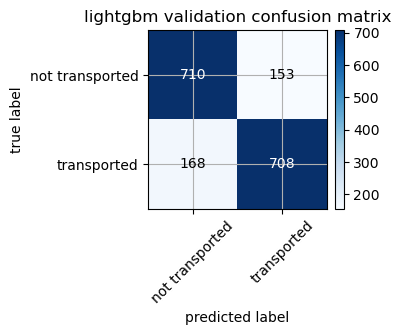

In [33]:
val_probs_lgb = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
val_preds_lgb = (val_probs_lgb >= 0.5).astype(int)

cm_lgb = confusion_matrix(y_val, val_preds_lgb)
print("lightgbm confusion matrix:\n", cm_lgb)
print("\nlightgbm classification report:\n", classification_report(y_val, val_preds_lgb, digits=4))
print("lightgbm val auc:", roc_auc_score(y_val, val_probs_lgb))

plot_confusion_matrix(cm_lgb, title="lightgbm validation confusion matrix")


## xgboost model

In [40]:
from xgboost import XGBClassifier

# model_xgb = XGBClassifier(
#     n_estimators=600,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=1.0,
#     reg_alpha=0.0,
#     objective="binary:logistic",
#     tree_method="hist",
#     eval_metric="logloss",
#     random_state=42,
# )

model_xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.025,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.5,
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
)

model_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True,
)


[0]	validation_0-logloss:0.68225
[1]	validation_0-logloss:0.67217
[2]	validation_0-logloss:0.66218
[3]	validation_0-logloss:0.65276
[4]	validation_0-logloss:0.64397
[5]	validation_0-logloss:0.63548
[6]	validation_0-logloss:0.62749
[7]	validation_0-logloss:0.61951
[8]	validation_0-logloss:0.61208
[9]	validation_0-logloss:0.60498
[10]	validation_0-logloss:0.59824
[11]	validation_0-logloss:0.59173
[12]	validation_0-logloss:0.58551
[13]	validation_0-logloss:0.57919
[14]	validation_0-logloss:0.57306
[15]	validation_0-logloss:0.56754
[16]	validation_0-logloss:0.56185
[17]	validation_0-logloss:0.55625
[18]	validation_0-logloss:0.55128
[19]	validation_0-logloss:0.54663
[20]	validation_0-logloss:0.54199
[21]	validation_0-logloss:0.53729
[22]	validation_0-logloss:0.53282
[23]	validation_0-logloss:0.52823
[24]	validation_0-logloss:0.52444
[25]	validation_0-logloss:0.52059
[26]	validation_0-logloss:0.51707
[27]	validation_0-logloss:0.51352
[28]	validation_0-logloss:0.50997
[29]	validation_0-loglos

[238]	validation_0-logloss:0.37251
[239]	validation_0-logloss:0.37261
[240]	validation_0-logloss:0.37250
[241]	validation_0-logloss:0.37245
[242]	validation_0-logloss:0.37237
[243]	validation_0-logloss:0.37252
[244]	validation_0-logloss:0.37236
[245]	validation_0-logloss:0.37212
[246]	validation_0-logloss:0.37207
[247]	validation_0-logloss:0.37199
[248]	validation_0-logloss:0.37195
[249]	validation_0-logloss:0.37182
[250]	validation_0-logloss:0.37179
[251]	validation_0-logloss:0.37179
[252]	validation_0-logloss:0.37174
[253]	validation_0-logloss:0.37147
[254]	validation_0-logloss:0.37139
[255]	validation_0-logloss:0.37132
[256]	validation_0-logloss:0.37124
[257]	validation_0-logloss:0.37131
[258]	validation_0-logloss:0.37115
[259]	validation_0-logloss:0.37108
[260]	validation_0-logloss:0.37107
[261]	validation_0-logloss:0.37081
[262]	validation_0-logloss:0.37064
[263]	validation_0-logloss:0.37064
[264]	validation_0-logloss:0.37070
[265]	validation_0-logloss:0.37067
[266]	validation_0-l

[473]	validation_0-logloss:0.36377
[474]	validation_0-logloss:0.36380
[475]	validation_0-logloss:0.36371
[476]	validation_0-logloss:0.36377
[477]	validation_0-logloss:0.36376
[478]	validation_0-logloss:0.36374
[479]	validation_0-logloss:0.36379
[480]	validation_0-logloss:0.36381
[481]	validation_0-logloss:0.36377
[482]	validation_0-logloss:0.36380
[483]	validation_0-logloss:0.36385
[484]	validation_0-logloss:0.36391
[485]	validation_0-logloss:0.36385
[486]	validation_0-logloss:0.36372
[487]	validation_0-logloss:0.36377
[488]	validation_0-logloss:0.36360
[489]	validation_0-logloss:0.36356
[490]	validation_0-logloss:0.36360
[491]	validation_0-logloss:0.36349
[492]	validation_0-logloss:0.36352
[493]	validation_0-logloss:0.36351
[494]	validation_0-logloss:0.36362
[495]	validation_0-logloss:0.36363
[496]	validation_0-logloss:0.36360
[497]	validation_0-logloss:0.36353
[498]	validation_0-logloss:0.36360
[499]	validation_0-logloss:0.36363


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.025, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## xgboost validation performance

xgboost confusion matrix:
 [[714 149]
 [161 715]]

xgboost classification report:
               precision    recall  f1-score   support

           0     0.8160    0.8273    0.8216       863
           1     0.8275    0.8162    0.8218       876

    accuracy                         0.8217      1739
   macro avg     0.8218    0.8218    0.8217      1739
weighted avg     0.8218    0.8217    0.8217      1739

xgboost val auc: 0.9136745556807779


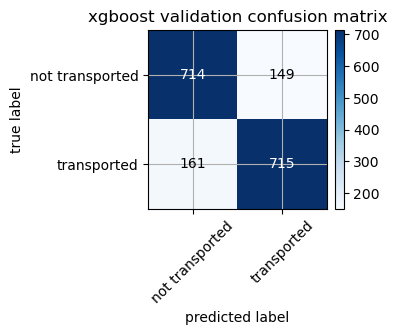

In [42]:
val_probs_xgb = model_xgb.predict_proba(X_val)[:, 1]
val_preds_xgb = (val_probs_xgb >= 0.5).astype(int)

cm_xgb = confusion_matrix(y_val, val_preds_xgb)
print("xgboost confusion matrix:\n", cm_xgb)
print("\nxgboost classification report:\n", classification_report(y_val, val_preds_xgb, digits=4))
print("xgboost val auc:", roc_auc_score(y_val, val_probs_xgb))

plot_confusion_matrix(cm_xgb, title="xgboost validation confusion matrix")


## ensemble validation performance

ensemble confusion matrix:
 [[664 199]
 [110 766]]

ensemble classification report:
               precision    recall  f1-score   support

           0     0.8579    0.7694    0.8112       863
           1     0.7938    0.8744    0.8322       876

    accuracy                         0.8223      1739
   macro avg     0.8258    0.8219    0.8217      1739
weighted avg     0.8256    0.8223    0.8218      1739

ensemble val auc: 0.9140912289613063
best weight: 0.12000000000000001
best threshold: 0.42000000000000004


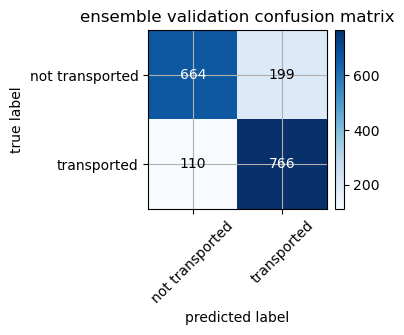

In [43]:
from sklearn.metrics import accuracy_score

weights = np.linspace(0.1, 0.9, 41)
best_acc = 0
for elem in weights:
    val_probs_ens = elem * val_probs_lgb + (1 - elem) * val_probs_xgb
    val_preds_ens = (val_probs_ens >= 0.5).astype(int)
    acc = accuracy_score(y_val, val_preds_ens)
    if acc > best_acc:
        best_acc = acc
        best_weight = elem
        
thresholds = np.linspace(0.1, 0.9, 41)
best_acc = 0
for elem in thresholds:
    val_probs_ens = best_weight * val_probs_lgb + (1 - best_weight) * val_probs_xgb
    val_preds_ens = (val_probs_ens >= elem).astype(int)
    acc = accuracy_score(y_val, val_preds_ens)
    if acc > best_acc:
        best_acc = acc
        best_threshold = elem
        
val_probs_ens = best_weight * val_probs_lgb + (1 - best_weight) * val_probs_xgb
val_preds_ens = (val_probs_ens >= best_threshold).astype(int)
cm_ens = confusion_matrix(y_val, val_preds_ens)
print("ensemble confusion matrix:\n", cm_ens)
print("\nensemble classification report:\n", classification_report(y_val, val_preds_ens, digits=4))
print("ensemble val auc:", roc_auc_score(y_val, val_probs_ens))
print("best weight:", best_weight)
print("best threshold:", best_threshold)

plot_confusion_matrix(cm_ens, title="ensemble validation confusion matrix")


## test predictions and submission

In [44]:
test_probs_lgb = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
test_probs_xgb = model_xgb.predict_proba(X_test)[:, 1]

test_probs_ens = best_weight * test_probs_lgb + (1 - best_weight) * test_probs_xgb
test_preds_ens = (test_probs_ens >= 0.5).astype(int)

RAW_DIRS = [
    "/kaggle/input/spaceship-titanic",
    "from_kaggle/cleaned_data",
    "from_kaggle",
    "/kaggle/working",
    "/kaggle/input",
]

def find_raw_test_path():
    for d in RAW_DIRS:
        p = os.path.join(d, "test.csv")
        if os.path.exists(p):
            return p
    raise FileNotFoundError("could not find raw test.csv for passenger ids")

raw_test_path = find_raw_test_path()
raw_test = pd.read_csv(raw_test_path)

submission = pd.DataFrame({
    "PassengerId": raw_test["PassengerId"].astype(str),
    "Transported": test_preds_ens.astype(bool),
})

submission_path = "ensemble_lgbm_xgboost.csv"
submission.to_csv(submission_path, index=False)
print("saved ensemble submission to:", submission_path)
submission.head()


saved ensemble submission to: ensemble_lgbm_xgboost.csv


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
